## COMP5623 Coursework on Image Classification with Convolutional Neural Networks 


###Starter code

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from  torch.utils.data import Dataset

from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import cv2

import torch.nn.functional
import keras
import tensorflow as tf
import errno
import shutil
from keras import backend as K

### Part I

The first part of the assignment is to build a CNN and train it on a subset of the ImageNet dataset. We will first create a dataframe with all the references to the images and their labels.

To download the images into your work environment, clone into a git respository containing the images.

In [0]:
! git clone https://github.com/MohammedAlghamdi/imagenet10.git

fatal: destination path 'imagenet10' already exists and is not an empty directory.


Check that the repository is there:

In [0]:
! ls

imagenet10  sample_data


In [0]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

A helper function for reading in images and assigning labels.

In [0]:
#获取文件路径以及标签
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_): #遍历目录
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

Now we create a dataframe using all the data.

In [0]:
# Benign images we will assign class 0, and malignant as 1
paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

View some sample data.

In [0]:
print("Found", len(data_df), "images.")
data_df.head()

Found 9000 images.


,path,class
0,imagenet10/train_set/dumbbell/n03255030_1631.JPEG,6
1,imagenet10/train_set/mug/n03797390_8747.JPEG,8
2,imagenet10/train_set/baboon/n02486410_4008.JPEG,0
3,imagenet10/train_set/football/n04254680_388.JPEG,7
4,imagenet10/train_set/dumbbell/n03255030_6128.JPEG,6


Now we will create the Dataset class.

In [0]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            1.image_dir (string): Directory with all the images
            2.df (DataFrame object): Dataframe containing the images, paths and classes
            3.transform (callable, optional): Optional transform to be appliedon a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

Compute what we should normalise the dataset to.

In [0]:
def compute_img_mean_std(image_paths):
    """
        计算均值和方差
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3) # 增加维度 https://blog.csdn.net/qq_17550379/article/details/78934529
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means)) #均值
    print("normStd = {}".format(stdevs)) #方差
    return means, stdevs


In [0]:
norm_mean, norm_std = compute_img_mean_std(paths)

100%|██████████| 9000/9000 [00:45<00:00, 198.65it/s]


(224, 224, 3, 9000)
normMean = [0.5228359, 0.4798834, 0.40605333]
normStd = [0.29770732, 0.28883994, 0.31178218]


###Dataset

Now let's create the transforms to normalise and turn our data into tensors.

In [0]:
#图像预处理   https://blog.csdn.net/hmh2_yy/article/details/85099523
data_transform = transforms.Compose([
        transforms.Resize(256), #256
        transforms.CenterCrop(256), #生成一个CenterCrop类的对象,256*256
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

Let's split the data into train and test sets and instantiate our new ISIC_Dataset objects.

In [0]:
train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

#ImageNet_Subset
ins_dataset_train = ImageNet10( #6300
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)

You will need to create DataLoaders for the datasets.

In [0]:
train_loader = torch.utils.data.DataLoader(
    dataset = ins_dataset_train,
    batch_size = 32, #一次迭代所使用的样本量
    shuffle = True,
    num_workers = 2,
)

validation_loader = torch.utils.data.DataLoader(
    dataset = ins_dataset_valid,
    batch_size = 32,
    shuffle = False,
    num_workers = 2,
)

test_loader = torch.utils.data.DataLoader(
    dataset = ins_dataset_test,
    batch_size = 64,# Forward pass only so batch size can be larger
    shuffle = False,
    num_workers = 2,
)
classes = np.arange(0, 10)

###Nerual Network

this is test code for question 1. Just change and run the code for doing question 1.

In [0]:
# # Convolutional neural network
# class ConvNet(nn.Module):
    '''this is test code for question 1. Just change and run the code for doing question 1.'''
#     def __init__(self, num_classes=10):
#         super(ConvNet, self).__init__()
  
#         self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1)
#         self.pool = nn.MaxPool2d(6,2)

#         self.conv2 = torch.nn.Sequential(
#             nn.Conv2d(in_channels = 16, out_channels = 24, kernel_size=4, stride=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=6, stride=2),
#             torch.nn.Dropout(0.3) 
#         )
#         self.conv3 = torch.nn.Sequential(
#             nn.Conv2d(in_channels = 24, out_channels = 32, kernel_size=4, stride=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=6, stride=2),
#             torch.nn.Dropout(0.3)
#         )
#         self.conv4 = torch.nn.Sequential(
#             nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=4, stride=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=6, stride=2),
#             torch.nn.Dropout(0.3)
#         )

#         self.fc1 = nn.Linear(5184, 512) 
#         self.fc2 = nn.Linear(512, num_classes)
        
#     def forward(self, x):
#         x = self.pool(torch.nn.functional.relu(self.conv1(x)))
#         x = torch.nn.functional.dropout(x, p=0.3)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = x.view(x.size(0),-1)
#         x = self.fc1(x)
#         out = self.fc2(x)

#         return out

'this is test code for question 1. Just change and run the code for doing question 1.'

In [0]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
  
        self.conv1 = torch.nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.3)
        )

        self.conv2 = torch.nn.Sequential(#容器,Sequential模块的初始换函数没有异常处理
            nn.Conv2d(in_channels = 16, out_channels = 24, kernel_size=3, stride=1),#stride移动步长 https://blog.csdn.net/weicao1990/article/details/80282837
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.3) #Dropout helps the neural network to avoid overfitting to noise in the training data.
        )
        self.conv3 = torch.nn.Sequential(
            nn.Conv2d(in_channels = 24, out_channels = 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.3)
        )
        self.conv4 = torch.nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 40, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.3)
        )
        self.conv5 = torch.nn.Sequential(
            nn.Conv2d(in_channels = 40, out_channels = 48, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.3)
        )
        self.conv6 = torch.nn.Sequential(
            nn.Conv2d(in_channels = 48, out_channels = 56, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(0.3)
        )


        # W' = (W - F + 2P) / S + 1   
        self.fc1 = nn.Linear(224, 112) #full-connected 全连接层的每一个结点都与上一层的所有结点相连，用来把前边提取到的特征综合起来
        self.fc2 = nn.Linear(112, num_classes)
        # self.final = nn.Softmax(dim=1) #将多个神经元的输出映射到（0,1）区间 https://www.zhihu.com/question/23765351/answer/240869755
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(x.size(0),-1) #将卷积的输出拉伸为一行, x.size() -- batch size, -1 -- 自适应 https://www.mediaat.cn/news/show-668.html
        x = self.fc1(x)
        out = self.fc2(x)

        return out

In [0]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [0]:
# Device configuration - defaults to CPU unless GPU is available on device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
device

device(type='cuda', index=0)

In [0]:
model_gpu = ConvNet().to(device)
model_gpu

ConvNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 40, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv5): Sequential(
    (0): Conv2d(40, 48, kernel_size=(3, 3), stride=(1, 1))
    (1): R

In [0]:
criterion = nn.CrossEntropyLoss()
# Stochastic gradient descent
 #v = mu * v - learning_rate * dw
 #w = w + v
 #lr = 0.001
optimizer = optim.SGD(model_gpu.parameters(), lr=0.001, momentum=0.9) #加速学习，0.9 - 10倍SDG算法

###Visualise filter before training

In [0]:
def prime_powers(n):
    """
    Compute the factors of a positive integer
    Algorithm from https://rosettacode.org/wiki/Factors_of_an_integer#Python
    :param n: int
    :return: set
    """
    factors = set()
    for x in range(1, int(math.sqrt(n)) + 1):
        if n % x == 0:
            factors.add(int(x))
            factors.add(int(n // x))
    return sorted(factors) #排序

In [0]:
def get_grid_dim(x):
    """
    Transforms x into product of two integers
    :param x: int
    :return: two ints
    """
    factors = prime_powers(x)
    if len(factors) % 2 == 0:
        i = int(len(factors) / 2)
        return factors[i], factors[i - 1]

    i = len(factors) // 2
    return factors[i], factors[i]

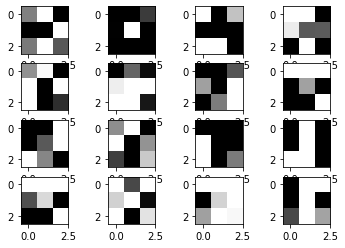

In [0]:
def visualise_filter_R_before(conv):
  filter = conv.weight.data.cpu().numpy()
  out_channels = filter.shape[0]
  rows = np.min(get_grid_dim(out_channels))
  columns = np.max(get_grid_dim(out_channels))
  length = filter.shape[1]
  width = filter.shape[2]
  channels  = filter.shape[3]

  for i in range(1, out_channels + 1):
    plt.subplot(rows, columns, i)
    filter_im = np.zeros((length, width, channels))
    filter[i-1] = (filter[i-1] - np.mean(filter[i-1])) / np.std(filter[i-1]) #符合正态分布
    filter[i-1] = np.minimum(1, np.maximum(0, (filter[i-1] + 0.5)))
    filter[i-1] = filter[i-1].transpose(1, 2, 0)#https://www.cnblogs.com/caizhou520/p/11227986.html

    filter_im = filter[i-1]
    plt.imshow(filter_im[:,:,0], cmap='gray')#cmap: 颜色图谱（colormap), 默认绘制为RGB(A)颜色空间 #https://www.cnblogs.com/denny402/p/5122594.html

visualise_filter_R_before(model_gpu.conv1)

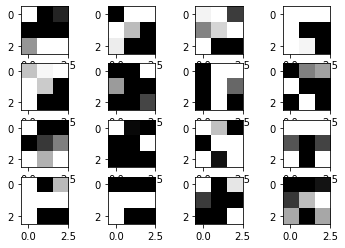

In [0]:
def visualise_filter_G_before(conv):
  filter = conv.weight.data.cpu().numpy()
  out_channels = filter.shape[0]
  rows = np.min(get_grid_dim(out_channels))
  columns = np.max(get_grid_dim(out_channels))
  length = filter.shape[1]
  width = filter.shape[2]
  channels  = filter.shape[3]

  for i in range(1, out_channels + 1):
    plt.subplot(rows, columns, i)
    filter_im = np.zeros((length, width, channels))
    filter[i-1] = (filter[i-1] - np.mean(filter[i-1])) / np.std(filter[i-1])
    filter[i-1] = np.minimum(1, np.maximum(0, (filter[i-1] + 0.5)))
    filter[i-1] = filter[i-1].transpose(1, 2, 0)

    filter_im = filter[i-1]
    plt.imshow(filter_im[:,:,1], cmap='gray')

visualise_filter_G_before(model_gpu.conv1)

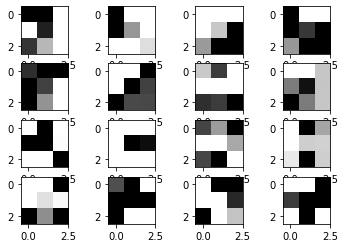

In [0]:
def visualise_filter_B_before(conv):
  filter = conv.weight.data.cpu().numpy()
  out_channels = filter.shape[0]
  rows = np.min(get_grid_dim(out_channels))
  columns = np.max(get_grid_dim(out_channels))
  length = filter.shape[1]
  width = filter.shape[2]
  channels  = filter.shape[3]

  for i in range(1, out_channels + 1):
    plt.subplot(rows, columns, i)
    filter_im = np.zeros((length, width, channels))
    filter[i-1] = (filter[i-1] - np.mean(filter[i-1])) / np.std(filter[i-1])
    filter[i-1] = np.minimum(1, np.maximum(0, (filter[i-1] + 0.5)))
    filter[i-1] = filter[i-1].transpose(1, 2, 0)

    filter_im = filter[i-1]
    plt.imshow(filter_im[:,:,2], cmap='gray')

visualise_filter_B_before(model_gpu.conv1)

###Training

In [0]:
import timeit

In [0]:
loss_list = []
acc_list = []

correct_train = 0
total_train = 0

total_val = 0
correct_val = 0
loss_list_val = []
acc_list_val = []

def train_model_epochs(num_epochs):
    """ Copy of function train_model_epochs but explicitly copying data to device during training. 
    """
    for epoch in range(num_epochs):

        running_loss = 0.0
        running_loss_val = 0.0
        batch_loss = 0.0
        length = len(train_loader)//10
        for i, data in enumerate(train_loader, 0):
            images, labels = data

            # Explicitly specifies that data is to be copied onto the device!
            images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
            labels = labels.to(device)  # <----------- variables still exist on CPU

            # Zero the parameter gradients means to reset them from any previous values. By default, gradients accumulate!
            optimizer.zero_grad()

            # Passing inputs to the model calls the forward() function of the Module class, and the outputs value contains the return value of forward()
            outputs = model_gpu(images)

            # Compute the loss based on the true labels
            loss = criterion(outputs, labels)

            # Backpropagate the error with respect to the loss
            loss.backward()

            # Updates the parameters based on current gradients and update rule;
            # in this case, defined by SGD()
            optimizer.step()

            global correct_train, total_train
            _, predicted = torch.max(outputs.data, 1) #tensor格式, dim = 1:取每一行的最大值
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Print our loss
            running_loss += loss.item() 
            batch_loss += loss.item()

            if i % length == length-1:    # print every length mini-batches
                print('Epoch / Batch [%d / %d] - Loss: %.3f - Acc:%.3f' %
                      (epoch + 1, i + 1, running_loss / length, (correct_train / total_train)))  
                running_loss = 0.0
                 
            if i == len(train_loader)-1:
                loss_list.append(batch_loss / len(train_loader))
                acc_list.append(correct_train / total_train)
                batch_loss = 0.0


        with torch.no_grad(): #不需要计算梯度，也不会进行反向传播
            for data_val in validation_loader:
                images_val, labels_val = data_val

                images_val = images_val.to(device) 
                labels_val = labels_val.to(device)

                outputs_val = model_gpu(images_val)

                loss_val = criterion(outputs_val, labels_val)
                running_loss_val += loss_val.item() 
                
                _, predicted = torch.max(outputs_val.data, 1) #tensor格式, dim = 1:取每一行的最大值
                global total_val, correct_val
                total_val += labels_val.size(0)
                correct_val += (predicted == labels_val).sum().item()



        print('- val_loss:%.3f - val_Acc:%.3f' % ((running_loss_val/len(validation_loader)), (correct_val / total_val)))
        loss_list_val.append(running_loss_val/len(validation_loader))
        acc_list_val.append(correct_val / total_val)
        running_loss_val = 0

In [0]:
# train_model_epochs(10)

###Visualise filter during halfway training

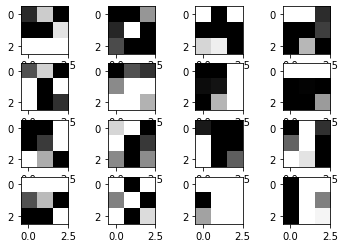

In [0]:
def visualise_filter_R_during(conv):
  filter = conv.weight.data.cpu().numpy()
  out_channels = filter.shape[0]
  rows = np.min(get_grid_dim(out_channels))
  columns = np.max(get_grid_dim(out_channels))
  length = filter.shape[1]
  width = filter.shape[2]
  channels  = filter.shape[3]

  for i in range(1, out_channels + 1):
    plt.subplot(rows, columns, i)
    filter_im = np.zeros((length, width, channels))
    filter[i-1] = (filter[i-1] - np.mean(filter[i-1])) / np.std(filter[i-1])
    filter[i-1] = np.minimum(1, np.maximum(0, (filter[i-1] + 0.5)))
    filter[i-1] = filter[i-1].transpose(1, 2, 0)

    filter_im = filter[i-1]
    plt.imshow(filter_im[:,:,0], cmap='gray')

visualise_filter_R_during(model_gpu.conv1)

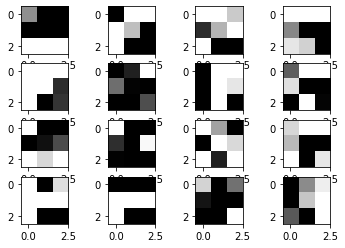

In [0]:
def visualise_filter_G_during(conv):
  filter = conv.weight.data.cpu().numpy()
  out_channels = filter.shape[0]
  rows = np.min(get_grid_dim(out_channels))
  columns = np.max(get_grid_dim(out_channels))
  length = filter.shape[1]
  width = filter.shape[2]
  channels  = filter.shape[3]

  for i in range(1, out_channels + 1):
    plt.subplot(rows, columns, i)
    filter_im = np.zeros((length, width, channels))
    filter[i-1] = (filter[i-1] - np.mean(filter[i-1])) / np.std(filter[i-1])
    filter[i-1] = np.minimum(1, np.maximum(0, (filter[i-1] + 0.5)))
    filter[i-1] = filter[i-1].transpose(1, 2, 0)

    filter_im = filter[i-1]
    plt.imshow(filter_im[:,:,1], cmap='gray')

visualise_filter_G_during(model_gpu.conv1)

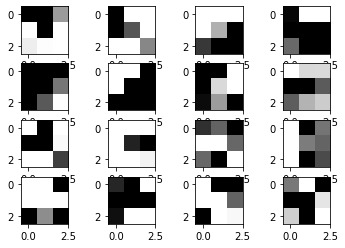

In [0]:
def visualise_filter_B_during(conv):
  filter = conv.weight.data.cpu().numpy()
  out_channels = filter.shape[0]
  rows = np.min(get_grid_dim(out_channels))
  columns = np.max(get_grid_dim(out_channels))
  length = filter.shape[1]
  width = filter.shape[2]
  channels  = filter.shape[3]

  for i in range(1, out_channels + 1):
    plt.subplot(rows, columns, i)
    filter_im = np.zeros((length, width, channels))
    filter[i-1] = (filter[i-1] - np.mean(filter[i-1])) / np.std(filter[i-1])
    filter[i-1] = np.minimum(1, np.maximum(0, (filter[i-1] + 0.5)))
    filter[i-1] = filter[i-1].transpose(1, 2, 0)

    filter_im = filter[i-1]
    plt.imshow(filter_im[:,:,2], cmap='gray')

visualise_filter_B_during(model_gpu.conv1)

###Training

In [0]:
gpu_train_time = timeit.timeit(
    "train_model_epochs(num_epochs)",
    setup="num_epochs=100",
    number=1,
    globals=globals(),
)

Epoch / Batch [1 / 19] - Loss: 2.303 - Acc:0.087
Epoch / Batch [1 / 38] - Loss: 2.306 - Acc:0.090
Epoch / Batch [1 / 57] - Loss: 2.299 - Acc:0.093
Epoch / Batch [1 / 76] - Loss: 2.292 - Acc:0.098
Epoch / Batch [1 / 95] - Loss: 2.282 - Acc:0.097
Epoch / Batch [1 / 114] - Loss: 2.277 - Acc:0.098
Epoch / Batch [1 / 133] - Loss: 2.267 - Acc:0.100
Epoch / Batch [1 / 152] - Loss: 2.257 - Acc:0.101
Epoch / Batch [1 / 171] - Loss: 2.257 - Acc:0.104
Epoch / Batch [1 / 190] - Loss: 2.252 - Acc:0.110
- val_loss:2.209 - val_Acc:0.182
Epoch / Batch [2 / 19] - Loss: 2.212 - Acc:0.116
Epoch / Batch [2 / 38] - Loss: 2.210 - Acc:0.120
Epoch / Batch [2 / 57] - Loss: 2.206 - Acc:0.126
Epoch / Batch [2 / 76] - Loss: 2.166 - Acc:0.132
Epoch / Batch [2 / 95] - Loss: 2.153 - Acc:0.136
Epoch / Batch [2 / 114] - Loss: 2.064 - Acc:0.141
Epoch / Batch [2 / 133] - Loss: 2.078 - Acc:0.146
Epoch / Batch [2 / 152] - Loss: 1.958 - Acc:0.154
Epoch / Batch [2 / 171] - Loss: 1.984 - Acc:0.160
Epoch / Batch [2 / 190] - L

###Visualise the filter after training

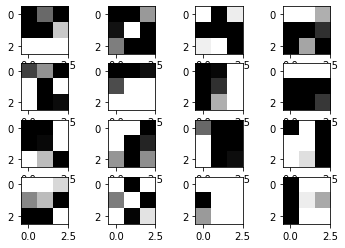

In [0]:
def visualise_filter_R_after(conv):
  filter = conv.weight.data.cpu().numpy()
  out_channels = filter.shape[0]
  rows = np.min(get_grid_dim(out_channels))
  columns = np.max(get_grid_dim(out_channels))
  length = filter.shape[1]
  width = filter.shape[2]
  channels  = filter.shape[3]

  for i in range(1, out_channels + 1):
    plt.subplot(rows, columns, i)
    filter_im = np.zeros((length, width, channels))
    filter[i-1] = (filter[i-1] - np.mean(filter[i-1])) / np.std(filter[i-1])
    filter[i-1] = np.minimum(1, np.maximum(0, (filter[i-1] + 0.5)))
    filter[i-1] = filter[i-1].transpose(1, 2, 0)

    filter_im = filter[i-1]
    plt.imshow(filter_im[:,:,0], cmap='gray')

visualise_filter_R_after(model_gpu.conv1)

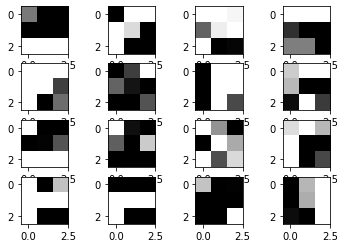

In [0]:
def visualise_filter_G_after(conv):
  filter = conv.weight.data.cpu().numpy()
  out_channels = filter.shape[0]
  rows = np.min(get_grid_dim(out_channels))
  columns = np.max(get_grid_dim(out_channels))
  length = filter.shape[1]
  width = filter.shape[2]
  channels  = filter.shape[3]

  for i in range(1, out_channels + 1):
    plt.subplot(rows, columns, i)
    filter_im = np.zeros((length, width, channels))
    filter[i-1] = (filter[i-1] - np.mean(filter[i-1])) / np.std(filter[i-1])
    filter[i-1] = np.minimum(1, np.maximum(0, (filter[i-1] + 0.5)))
    filter[i-1] = filter[i-1].transpose(1, 2, 0)

    filter_im = filter[i-1]
    plt.imshow(filter_im[:,:,1], cmap='gray')

visualise_filter_G_after(model_gpu.conv1)

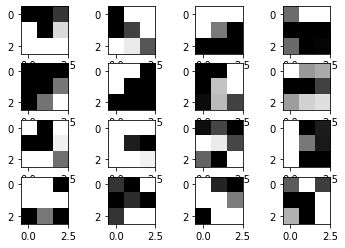

In [0]:
def visualise_filter_B_after(conv):
  filter = conv.weight.data.cpu().numpy()
  out_channels = filter.shape[0]
  rows = np.min(get_grid_dim(out_channels))
  columns = np.max(get_grid_dim(out_channels))
  length = filter.shape[1]
  width = filter.shape[2]
  channels  = filter.shape[3]

  for i in range(1, out_channels + 1):
    plt.subplot(rows, columns, i)
    filter_im = np.zeros((length, width, channels))
    filter[i-1] = (filter[i-1] - np.mean(filter[i-1])) / np.std(filter[i-1])
    filter[i-1] = np.minimum(1, np.maximum(0, (filter[i-1] + 0.5)))
    filter[i-1] = filter[i-1].transpose(1, 2, 0)

    filter_im = filter[i-1]
    plt.imshow(filter_im[:,:,2], cmap='gray')

visualise_filter_B_after(model_gpu.conv1)

###Training

In [0]:
# gpu_train_time

In [0]:
correct = 0
total = 0
labels_list = []
predicted_list = []

with torch.no_grad(): #https://blog.csdn.net/weixin_43178406/article/details/89517008
    
    # Iterate over the test set
    for data in test_loader:
        images, labels = data


        # Explicitly specifies that data is to be copied onto the device!
        images = images.to(device)  # <----------- And note it's NOT an in-place operation; original
        labels = labels.to(device)  # <----------- variables still exist on CPU

        outputs = model_gpu(images)
        
        # torch.max is an argmax operation
        _, predicted = torch.max(outputs.data, 1) #tensor格式, dim = 1:取每一行的最大值
        
        labels_list += labels.tolist()
        predicted_list += predicted.tolist()
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()



print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 64 %


In [0]:
# torch.save(model_gpu, '/content/sample_data/my_modle.pt') 

Visualise accuracy and loss for traininig set

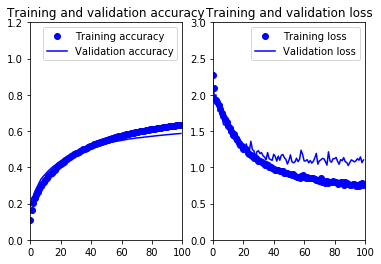

In [0]:
epochs = range(len(acc_list))
nb_epochs = len(epochs)

f2 = plt.figure(2)
plt.subplot(1, 2, 1)
plt.axis((0, nb_epochs, 0, 1.2))
plt.plot(epochs, acc_list, 'bo', label='Training accuracy')
plt.plot(epochs, acc_list_val, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.axis((0, nb_epochs, 0, 3))
plt.plot(epochs, loss_list, 'bo', label='Training loss')
plt.plot(epochs, loss_list_val, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.draw()
plt.pause(0.001)

Confusion matirx

In [0]:
#https://forums.fast.ai/t/attributeerror-memoryview-object-has-no-attribute-cpu-and-runtimeerror-number-of-dims-dont-match-in-permute/24448
cm = confusion_matrix(torch.as_tensor(labels_list),torch.as_tensor(predicted_list)) 

In [0]:
cm

array([[123,   7,  18,  21,   1,   0,   6,  17,   1,   0],
       [  1, 144,   5,   0,   4,   1,   3,   0,  11,  10],
       [  1,   7, 129,   2,   8,   3,   5,  13,   4,   1],
       [  9,  10,   9, 126,   3,   3,   9,   3,   9,   0],
       [  0,   5,   2,   1, 126,  11,  10,   4,  30,   0],
       [  2,   8,   4,   0,  12,  92,  30,  12,  20,   0],
       [  2,   9,   3,   1,  14,  19,  90,  10,  34,   1],
       [  1,  12,  17,   7,   6,   9,  14,  97,  31,   2],
       [  0,   7,   2,   3,   2,   7,  11,  12, 113,   0],
       [  1,  27,   1,   0,   0,   4,   2,   5,   6, 122]])

In [0]:
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix very prettily.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # The data formatting
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Confusion matrix, without normalization


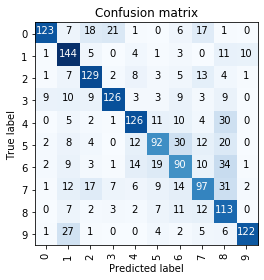

In [0]:
plot_confusion_matrix(cm, classes)

###Feature map visualisation

In [0]:
img_loader = torch.utils.data.DataLoader(
    dataset = ins_dataset_train,
    batch_size = 1, #一次迭代所使用的样本量
    shuffle = True,
    num_workers = 2,
)

In [0]:
for i, data in enumerate(img_loader, 0):
  images, labels = data

  images = images.to(device)
  labels = labels.to(device)

  if i == 0:
    img1 = images
  elif i == 1:
    img2 = images
  else:
    break

In [0]:
def layer_hook(self, input, output):
  plt.figure(figsize=(10, 10))
  for i in range(4):
    plt.subplot(4, 4, i+1)
    ft = output.data.clone().cpu()
    plt.imshow(ft[0,i,:,:,], cmap = 'gray')
    # print(ft[0,i:,:,].size())
  plt.show()

In [0]:
handle = model_gpu.conv1.register_forward_hook(layer_hook)
handle = model_gpu.conv2.register_forward_hook(layer_hook)
handle = model_gpu.conv3.register_forward_hook(layer_hook)
handle = model_gpu.conv4.register_forward_hook(layer_hook)
# handle = model_gpu.conv5.register_forward_hook(layer_hook)

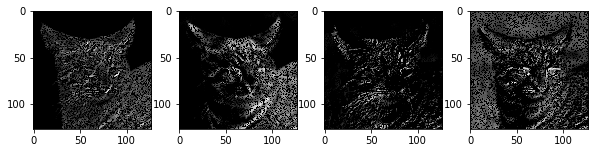

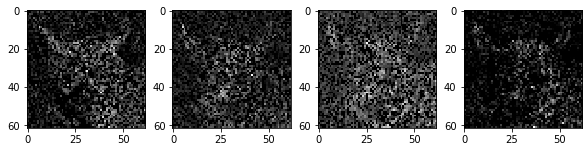

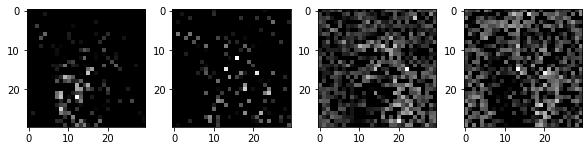

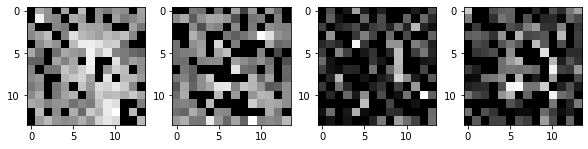

tensor([[-0.0761,  0.0255, -0.0024,  0.0342, -0.0616,  0.0572, -0.0362,  0.1002,
         -0.0472, -0.1118]], device='cuda:0', grad_fn=<AddmmBackward>)

In [0]:
model_gpu(img1)

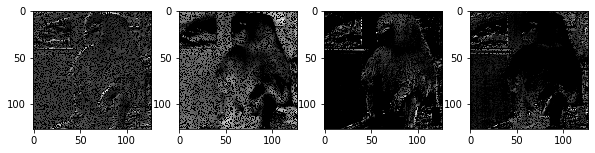

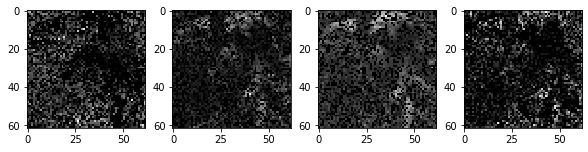

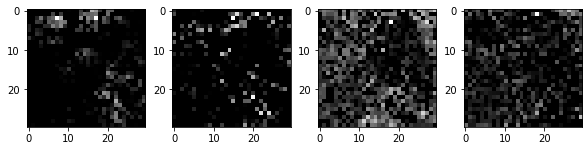

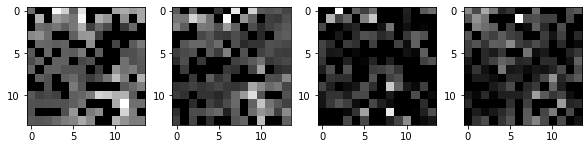

tensor([[-0.1285,  0.0297,  0.0509,  0.0602, -0.0531,  0.0423, -0.0058,  0.0656,
         -0.0452, -0.1257]], device='cuda:0', grad_fn=<AddmmBackward>)

In [0]:
model_gpu(img2)